## Canine attributes study
Michael Suttles

In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 200

## Code: import the data

In [2]:
nyc_registry = pd.read_csv('../dogdata/NYC_Dog_Licensing_Dataset_2015-edit.csv')
coren = pd.read_csv('../dogdata/coren-edit.csv')
# nyc_census = pd.read_csv('../censusdata/ACS_16_1YR_S0201_with_ann-edit.csv') # use 2016 data
edmonton_registry = pd.read_csv('../dogdata/Edmonton_Pet_Licenses_by_Neighbourhood_2018-edit.csv')
adelaide_registry = pd.read_csv('../dogdata/Dog_Registrations_Adelaide_2016-edit.csv')
seattle_registry = pd.read_csv('../dogdata/Seattle_Pet_Licenses-2018-edit2.csv')
wiki = pd.read_csv('../dogdata/wiki-edit.csv')
turcsan = pd.read_csv('../dogdata/turcsan.csv')

# List of attributes
# lst = ['Trainable', 'Obedient', 'Bold', 'Calm','Sociable']
lst = ['Trainable', 'Bold', 'Calm','Sociable']
borough = ['Bronx','Brooklyn','Manhattan','Queens','Staten Island']
# Pare down the Coren data
coren = coren[['Breed', 'Obedient']]
# Combine the Coren and Turcsan datasets
attrib = coren.set_index('Breed').join(turcsan.set_index('Breed'), how='outer')

In [3]:
adelaide_registry.replace(to_replace='Labrador',value='Labrador Retriever', inplace=True)

## Code: functions to display and manage data

In [4]:
def describe(df, categ, filename=None, display=True):
    """Show the mean and standard deviation of the data and optionally plot. Optionally save a file of the plot.
    
    Arguments:
        df {DataFrame} -- DataFrame to describe
        categ {str} -- Display category
    
    Keyword Arguments:
        filename {str} -- Name of file to save to (default: {None})
        display {bool} -- Whether or not to display a plot (default: {True})
    """
    print('\n'+categ+' Mean')
    attrib_mean = df[lst].mean()
    print(attrib_mean.round(decimals=2))
    print('\n'+categ+' Standard Deviation')
    print(attrib[lst].std().round(decimals=2))

    plt.title(categ+' Overall Attributes')
    plt.bar(attrib_mean.index, attrib_mean.values)
    plt.ylim([0,0.75])
    if filename is not None:
        plt.savefig('../plots/'+filename)
    if display:
        plt.show()

def describe_breeds(save=False):
    '''Show the intersection of different breeds of dogs according to which dataset they come from. For example, Dogue de Bordeaux is in the Turcsan set but not in the Wiki scraped set.

    Returns:
        None
    '''
    wiki_breeds = set(wiki['Breed'].tolist())
    coren_breeds = set(coren['Breed'].tolist())
    turcsan_breeds = set(turcsan['Breed'].tolist())

    print('\nIntersection, Wiki and Turcsan')
    print(wiki_breeds & turcsan_breeds)
    print('\nIntersection, Wiki and Coren')
    print(wiki_breeds & coren_breeds)
    print('\nDifference, Wiki - Turcsan')
    print(wiki_breeds - turcsan_breeds)
    print('\nDifference, Turcsan - Wiki')
    print(turcsan_breeds - wiki_breeds)
    print('\nDifference, Wiki - Coren')
    print(wiki_breeds - coren_breeds)
    print('\nDifference, Coren - Wiki')
    print(coren_breeds - wiki_breeds)

def plot_by_attrib(df, categ,label, filename=None, display=True):
    """Plot a graph by the attributes provided.
    
    Arguments:
        df {DataFrame} -- DF to plot
        categ {list} -- Categories to plot
        label {str} -- Label for what the data is describing
    
    Keyword Arguments:
        filename {str} -- Name of the file to optionally save (default: {None})
        display {bool} -- Whether or not to display the plot (default: {True})
    """
    fig, ax = plt.subplots()
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    for item in categ:
        ax.plot(df.index, df[item])

    plt.gcf().subplots_adjust(bottom=0.3, right=.75)
    plt.legend(loc=(1.04,0.6))
    plt.title('Scores by '+ label)
    ax.set_ylabel('Score')
    ax.set_xlabel(label)
    if filename is not None:
        plt.savefig('../plots/'+filename)
    if display:
        plt.show()


def splitDataFrameList(df,target_column,separator):
    """Thanks to James Allen, https://gist.github.com/jlln/338b4b0b55bd6984f883
    
    Arguments:
        df {DataFrame} -- DataFrame to split,
        target_column {string} -- The column containing the values to split
        separator {str} -- The symbol used to perform the split
    
    Returns:
        DataFrame -- A dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    """
    def splitListToRows(row,row_accumulator,target_column,separator):
        split_row = row[target_column].split(separator)
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)
    new_rows = []
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column,separator))
    new_df = pd.DataFrame(new_rows)
    return new_df

## Summary statistics

In [5]:
print('Note: for a 1-year period varying from 2015-2018')
print('New York total dogs: ',nyc_registry.shape[0])
print('Seattle total dogs:  ',seattle_registry.shape[0])
print('Edmonton total dogs: ',edmonton_registry.shape[0])
print('Adelaide total dogs: ',adelaide_registry.shape[0])

Note: for a 1-year period varying from 2015-2018
New York total dogs:  121950
Seattle total dogs:   18227
Edmonton total dogs:  59266
Adelaide total dogs:  16075


There is something wrong with the Seattle dataset. For example, in 2015 there were only approx 206 dogs registered.

## Dog ownership by population

In [6]:
ny_pop = 8582000
seattle_pop = 3870000
edmonton_pop = 966000
adelaide_pop = 1340000

print('New York ownership/reporting percentage: ',round(100*nyc_registry.shape[0]/ny_pop,3))
print('Seattle ownership/reporting percentage: ',round(100*seattle_registry.shape[0]/seattle_pop,3))
print('Edmonton ownership/reporting percentage: ',round(100*edmonton_registry.shape[0]/edmonton_pop,3))
print('Adelaide ownership/reporting percentage: ',round(100*adelaide_registry.shape[0]/adelaide_pop,3))

New York ownership/reporting percentage:  1.421
Seattle ownership/reporting percentage:  0.471
Edmonton ownership/reporting percentage:  6.135
Adelaide ownership/reporting percentage:  1.2


The widely varying percentages imply there may be a problem with some of the data--especially in Seattle, as noted above. Edmonton has an abnormally high percentage.

## Correlation coefficients among attributes

In [7]:
attrib.corr()

,Obedient,Calm,Trainable,Sociable,Bold
Obedient,1.000000,-0.224701,0.363011,-0.187287,-0.200141
Calm,-0.224701,1.000000,-0.596697,0.864370,0.753806
Trainable,0.363011,-0.596697,1.000000,-0.331093,-0.409075
Sociable,-0.187287,0.864370,-0.331093,1.000000,0.815936
Bold,-0.200141,0.753806,-0.409075,0.815936,1.000000


## Show which dogs are in each dataset

In [8]:
describe_breeds()


Intersection, Wiki and Turcsan
{'Alaskan Malamute', 'English Setter', 'Yorkshire Terrier', 'Brittany', 'Shiba Inu', 'Standard Schnauzer', 'Poodle', 'German Shorthaired Pointer', 'Shar Pei', 'Lhasa Apso', 'Chihuahua', 'Great Dane', 'Doberman Pinscher', 'Irish Wolfhound', 'Whippet', 'Boxer', 'Pekingese', 'Ibizan Hound', 'Jack Russell Terrier', 'American Staffordshire Terrier', 'Bull Terrier', 'Dachshund', 'Bulldog', 'Cavalier King Charles Spaniel', 'Rhodesian Ridgeback', 'Polish Lowland Sheepdog', 'Shih Tzu', 'Irish Terrier', 'Soft-Coated Wheaten Terrier', 'Dalmatian', 'Gordon Setter', 'Belgian Malinois', 'Rottweiler', 'Beagle', 'Giant Schnauzer', 'Irish Setter', 'Labrador Retriever', 'Briard', 'Border Terrier', 'French Bulldog', 'Saint Bernard', 'German Shepherd', 'Airedale Terrier', 'Border Collie', 'German Wirehaired Pointer', 'Weimaraner', 'Bernese Mountain Dog', 'Bearded Collie', 'Miniature Poodle', 'Maltese', 'Vizsla', 'Flat-Coated Retriever', 'Beauceron', 'Cairn Terrier', 'Austra

# Attributes by AKC groupings
Similar to what Turcsán did in her paper


AKC Mean
              Obedient  Calm  Trainable  Sociable  Bold
AKC                                                    
Herding           0.77  0.30       0.85      0.45  0.30
Hound             0.44  0.50       0.67      0.58  0.33
Non-Sporting      0.53  0.44       0.67      0.44  0.22
Sporting          0.73  0.67       0.62      0.67  0.62
Terrier           0.51  0.30       0.75      0.30  0.35
Toy               0.42  0.62       0.25      0.56  0.69
Working           0.60  0.45       0.73      0.41  0.36

AKC Standard Deviation
              Obedient  Calm  Trainable  Sociable  Bold
AKC                                                    
Herding           0.20  0.48       0.24      0.44  0.48
Hound             0.14  0.55       0.41      0.38  0.52
Non-Sporting      0.23  0.53       0.43      0.39  0.44
Sporting          0.15  0.49       0.38      0.44  0.48
Terrier           0.17  0.48       0.35      0.48  0.47
Toy               0.21  0.52       0.27      0.50  0.37
Working       

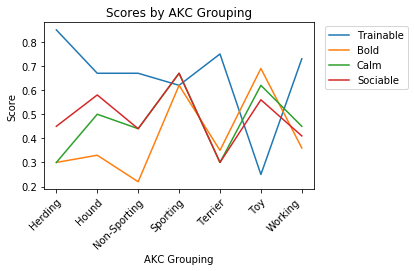

In [9]:
wiki_akc = wiki[['Breed', 'AKC']]
akc_groups_attrib = wiki_akc.set_index('Breed').join(attrib, how='left')
print('\nAKC Mean')
akc = akc_groups_attrib.groupby('AKC').mean().round(decimals=2)
pprint(akc)
print('\nAKC Standard Deviation')
akc_std = akc_groups_attrib.groupby('AKC').std().round(decimals=2)
pprint(akc_std)
print('\nAKC Count')
akc_count = akc_groups_attrib.groupby('AKC').count()
pprint(akc_count)

# Plot the AKC grouping data
plot_by_attrib(akc, lst, 'AKC Grouping')

## Display breed attributes by NYC borough


NYC Mean:
               Calm  Trainable  Sociable  Bold
Borough                                       
Bronx          0.40       0.35      0.40  0.60
Brooklyn       0.45       0.43      0.46  0.60
Manhattan      0.51       0.47      0.52  0.62
Queens         0.46       0.41      0.47  0.62
Staten Island  0.51       0.44      0.51  0.64

NYC Standard Deviation:
               Calm  Trainable  Sociable  Bold
Borough                                       
Bronx          0.49       0.36      0.48  0.36
Brooklyn       0.50       0.37      0.49  0.40
Manhattan      0.50       0.36      0.49  0.41
Queens         0.50       0.36      0.48  0.39
Staten Island  0.50       0.35      0.49  0.40

NYC Count:
                Calm  Trainable  Sociable   Bold
Borough                                         
Bronx           5827       5827      5827   5827
Brooklyn       13079      13079     13079  13079
Manhattan      19095      19095     19095  19095
Queens         11044      11044     11044  11044


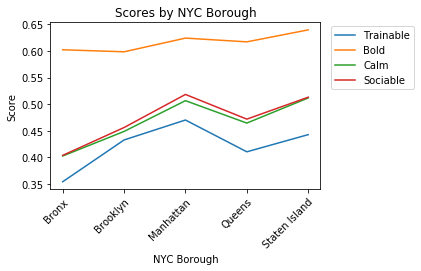


Top NYC Dogs Count
Yorkshire Terrier                7412
Shih Tzu                         6835
Chihuahua                        5555
Maltese                          4117
Labrador Retriever               4055
Pit Bull Mix                     3279
American Pit Bull Terrier        3196
Labrador Retriever Crossbreed    2677
Pomeranian                       2107
Beagle                           2017
Jack Russell Terrier             1962
Havanese                         1962
Name: BreedName, dtype: int64

Top Dogs By Borough

Bronx
Yorkshire Terrier                1171
Shih Tzu                         1046
Chihuahua                         830
American Pit Bull Terrier         689
Pit Bull Mix                      513
Maltese                           510
Labrador Retriever                246
Pomeranian                        241
German Shepherd Dog               216
Shih Tzu Crossbreed               188
Jack Russell Terrier              180
Labrador Retriever Crossbreed     178
Name: Bree

In [10]:
# Strip out NYC dirty values
nyc_registry['Borough'] = nyc_registry['Borough'].map(lambda x: None if x not in {'Brooklyn', 'Bronx', 'Staten Island', 'Manhattan', 'Queens'} else x)
nyc_registry.replace(to_replace='Unknown',value=np.nan, inplace=True)
nyc_registry.replace(to_replace='American Pit Bull Mix / Pit Bull Mix',value='Pit Bull Mix', inplace=True)
nyc_registry.replace(to_replace='American Pit Bull Terrier/Pit Bull',value='American Pit Bull Terrier', inplace=True)
nyc_registry.dropna(inplace=True)

display = True # Display the graph
norm=False # Whether or not to normalize
nyc_attrib = nyc_registry.set_index('BreedName').join(attrib, how='left')
# nyc_attrib = nyc_attrib[['Borough','Calm', 'Trainable', 'Sociable', 'Bold', 'Obedient']]
nyc_attrib = nyc_attrib[['Borough','Calm', 'Trainable', 'Sociable', 'Bold']]
nyc_attrib_g = nyc_attrib.groupby('Borough')
print('\nNYC Mean:')
nyc_attrib_g_mean = nyc_attrib_g.mean()
pprint(nyc_attrib_g_mean.round(decimals=2))
print('\nNYC Standard Deviation:')
pprint(nyc_attrib_g.std().round(decimals=2))
print('\nNYC Count:')
pprint(nyc_attrib_g.count())
if display:
    plot_by_attrib(nyc_attrib_g_mean, lst, 'NYC Borough')

nyc_breeds = nyc_registry[['Borough', 'BreedName']]
print('\nTop NYC Dogs Count')
pprint(nyc_breeds['BreedName'].value_counts().nlargest(12))
nyc_breeds_grp = nyc_breeds.groupby('Borough')
print('\nTop Dogs By Borough')
for b in borough:
    print('\n'+b)
    print(nyc_breeds_grp.get_group(b)['BreedName'].value_counts(normalize=norm).head(12))

## Perform Chi-Squared analysis on NYC data
Are the distributions of dogs in NYC statistically significant with respect to which borough one is in? I look at the five most common breeds, pairwise.

In [11]:
chi2_breed = ['Yorkshire Terrier', 'Shih Tzu','Chihuahua', 'Maltese', 'Labrador Retriever']
chi2_breed_com = itertools.combinations(chi2_breed, 2)
nyc_breeds_5 = nyc_registry[nyc_registry['BreedName'].isin(chi2_breed)] #top 5 breeds overall
for i in chi2_breed_com:
    print('\n',i)
    nyc_breeds_2 = nyc_registry[nyc_registry['BreedName'].isin(i)]
    contingency_table = pd.crosstab(nyc_breeds_2['BreedName'], nyc_breeds_2['Borough'])
    nyc_chi2 = stats.chi2_contingency(contingency_table)
    print('Test statistic: {}'.format(nyc_chi2[0].round(2)))
    print('P-value: {}'.format(nyc_chi2[1]))


 ('Yorkshire Terrier', 'Shih Tzu')
Test statistic: 6.0
P-value: 0.19935815394309653

 ('Yorkshire Terrier', 'Chihuahua')
Test statistic: 98.16
P-value: 2.429327716068869e-20

 ('Yorkshire Terrier', 'Maltese')
Test statistic: 72.38
P-value: 7.147745625233244e-15

 ('Yorkshire Terrier', 'Labrador Retriever')
Test statistic: 409.12
P-value: 2.980385866171689e-87

 ('Shih Tzu', 'Chihuahua')
Test statistic: 133.21
P-value: 7.994705402523028e-28

 ('Shih Tzu', 'Maltese')
Test statistic: 76.64
P-value: 8.981695413046296e-16

 ('Shih Tzu', 'Labrador Retriever')
Test statistic: 411.94
P-value: 7.309724499346304e-88

 ('Chihuahua', 'Maltese')
Test statistic: 147.63
P-value: 6.557578045686694e-31

 ('Chihuahua', 'Labrador Retriever')
Test statistic: 343.14
P-value: 5.304888286870627e-73

 ('Maltese', 'Labrador Retriever')
Test statistic: 289.52
P-value: 1.9691645730782012e-61


The distribution of *all* dog breeds in NYC based on the borough is statistially significant except for the distribution of Yorkshire Terriers vs. Shih Tzus. 

## Seattle dog attributes
Seattle data includes ONLY dogs with a primary breed. Secondary breeds are excluded.

In [12]:
seattle_attrib = seattle_registry[pd.isnull(seattle_registry['Secondary Breed'])]
seattle_attrib = seattle_registry.set_index('Primary Breed').join(attrib, how='left')
seattle_attrib

,License Issue Date,License Number,Animal's Name,Species,Secondary Breed,ZIP Code,Obedient,Calm,Trainable,Sociable,Bold
Affenpinscher,April 18 2018,210596,Poirot,Dog,NaN,98102,0.70,NaN,NaN,NaN,NaN
Affenpinscher,March 21 2018,126404,Lucky,Dog,NaN,98104,0.70,NaN,NaN,NaN,NaN
Afghan Hound,July 23 2018,S119455,Asteria,Dog,NaN,98122,0.25,NaN,NaN,NaN,NaN
Afghan Hound,May 01 2018,141025,Abby,Dog,NaN,98138,0.25,NaN,NaN,NaN,NaN
Afghan Hound,July 23 2018,S119454,Atlas,Dog,NaN,98122,0.25,NaN,NaN,NaN,NaN
Afghan Hound,May 31 2018,139371,Luca,Dog,NaN,98108,0.25,NaN,NaN,NaN,NaN
Airedale Terrier,December 13 2018,955156,Otis,Dog,NaN,98103,0.70,1.0,0.5,1.0,1.0
Airedale Terrier,November 06 2018,903738,Winston,Dog,NaN,98101,0.70,1.0,0.5,1.0,1.0
Airedale Terrier,November 14 2018,903865,Hogan,Dog,NaN,98125,0.70,1.0,0.5,1.0,1.0
Airedale Terrier,October 31 2018,S122731,Daisy,Dog,Golden Retriever,98133,0.70,1.0,0.5,1.0,1.0


In [13]:
seattle_attrib.describe()

,Obedient,Calm,Trainable,Sociable,Bold
count,14513.000000,12673.000000,12673.000000,12673.000000,12673.000000
mean,0.670327,0.551882,0.597293,0.577961,0.598161
std,0.266143,0.497321,0.331260,0.472030,0.457333
min,0.250000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.000000,0.500000,0.000000,0.000000
50%,0.700000,1.000000,0.500000,1.000000,1.000000
75%,0.950000,1.000000,1.000000,1.000000,1.000000
max,0.950000,1.000000,1.000000,1.000000,1.000000


In [14]:
# seattle_attrib_pri = seattle_registry.set_index('Primary Breed').join(attrib, how='left')
# seattle_attrib_sec = seattle_registry.set_index('Secondary Breed').join(attrib, how='left')

# seattle_attrib_pri.set_index('License Number', inplace=True)
# seattle_attrib_sec.set_index('License Number', inplace=True)

# seattle_attrib = seattle_attrib_pri.join(seattle_attrib_sec.drop(columns=['Animal\'s Name','License Issue Date','Species','ZIP Code']),\
#                                          how='left', rsuffix='_sec')

# # Didn't do Obedient
# seattle_attrib['Bold2'] = np.where(pd.isnull(seattle_attrib['Bold_sec']), seattle_attrib['Bold'], \
#                                   (seattle_attrib['Bold_sec']))
# seattle_attrib['Bold'] = (seattle_attrib['Bold2'] + seattle_attrib['Bold'])/2
# seattle_attrib['Calm2'] = np.where(pd.isnull(seattle_attrib['Calm_sec']), seattle_attrib['Calm'], \
#                                   (seattle_attrib['Calm_sec']))
# seattle_attrib['Calm'] = (seattle_attrib['Calm2'] + seattle_attrib['Calm'])/2
# seattle_attrib['Trainable2'] = np.where(pd.isnull(seattle_attrib['Trainable_sec']), seattle_attrib['Trainable'], \
#                                   (seattle_attrib['Trainable_sec']))
# seattle_attrib['Trainable'] = (seattle_attrib['Trainable2'] + seattle_attrib['Trainable'])/2
# seattle_attrib['Sociable2'] = np.where(pd.isnull(seattle_attrib['Sociable_sec']), seattle_attrib['Sociable'], \
#                                   (seattle_attrib['Sociable_sec']))
# seattle_attrib['Sociable'] = (seattle_attrib['Sociable2'] + seattle_attrib['Sociable'])/2


# seattle_attrib.drop(columns=['Bold_sec','Bold2','Sociable_sec','Sociable2','Calm2','Calm_sec','Trainable2'\
#                             ,'Trainable_sec'], inplace=True)

# Perform hypothesis tests for NYC boroughs

In [15]:
print('Alternative Hypothesis: dogs from Staten Island are bolder than other dogs in New York.')
non_staten = nyc_attrib[nyc_attrib['Borough'].isin(['Manhattan', 'Queens', 'Bronx', 'Brooklyn'])]
non_staten.dropna(inplace=True)
non_staten_bold = non_staten['Bold']
print('Non-Staten Island bold mean: ',non_staten_bold.mean())
staten = nyc_attrib[nyc_attrib['Borough'] == 'Staten Island']
staten.dropna(inplace=True)
staten_bold = staten['Bold']
print('Staten Island bold mean: ',staten_bold.mean())
print(stats.ttest_ind(staten_bold, non_staten_bold, equal_var = False))

print('\nAlternative Hypothesis: dogs from Staten Island are calmer than other dogs in New York.')
non_staten_calm = non_staten['Calm']
print('Non-Staten Island calm mean: ',non_staten_calm.mean())
staten_calm = staten['Calm']
print('Staten Island calm mean: ',staten_calm.mean())
print(stats.ttest_ind(staten_calm, non_staten_calm, equal_var = False))

print('\nAlternative Hypothesis: dogs from the Bronx and Queens are less trainable than other dogs in New York.')
non_bronxq = nyc_attrib[nyc_attrib['Borough'].isin(['Manhattan', 'Staten Island', 'Brooklyn'])]
non_bronxq.dropna(inplace=True)
non_bronxq_trainable = non_bronxq['Trainable']
print('Non-Bronx/Queens trainable mean: ',non_bronxq_trainable.mean())
bronxq = nyc_attrib[nyc_attrib['Borough'].isin(['Queens', 'Bronx'])]
bronxq.dropna(inplace=True)
bronxq_trainable = bronxq['Trainable']
print('Bronx/Queens trainable mean: ',bronxq_trainable.mean())
print(stats.ttest_ind(bronxq_trainable, non_bronxq_trainable, equal_var = False))

print('\nAlternative Hypothesis: dogs from the Bronx and Queens are less sociable than other dogs in New York.')
non_bronxq_sociable = non_bronxq['Sociable']
print('Non-Bronx/Queens sociable mean: ',non_bronxq_sociable.mean())
bronxq_sociable = bronxq['Sociable']
print('Bronx/Queens sociable mean: ',bronxq_sociable.mean())
print(stats.ttest_ind(non_bronxq_sociable, bronxq_sociable, equal_var = False))

print('\nNull Hypothesis: The average boldness of dogs in Brooklyn is the same as the average boldness for other New York dogs.')
print('Alternative Hypothesis: The average boldness of Brooklyn and other New York dogs is different.')
non_brooklyn = nyc_attrib[nyc_attrib['Borough'].isin(['Manhattan', 'Queens', 'Bronx', 'Staten Island'])]
non_brooklyn.dropna(inplace=True)
non_brooklyn_bold = non_brooklyn['Bold']
print('Non-Brooklyn bold mean: ',non_brooklyn_bold.mean())
brooklyn = nyc_attrib[nyc_attrib['Borough'] == 'Brooklyn']
brooklyn.dropna(inplace=True)
brooklyn_bold = staten['Bold']
print('Brooklyn bold mean: ',brooklyn_bold.mean())
print(stats.ttest_ind(brooklyn_bold, non_brooklyn_bold, equal_var = False))

print('\nNull Hypothesis: The average trainability of dogs in Brooklyn is the same as the average trainability for other New York dogs.')
print('Alternative Hypothesis: The average trainability of Brooklyn and other New York dogs is different.')
non_brooklyn_trainable = non_brooklyn['Trainable']
print('Non-Brooklyn trainable mean: ',non_brooklyn_trainable.mean())
brooklyn_trainable = brooklyn['Trainable']
print('Brooklyn trainable mean: ',brooklyn_trainable.mean())
print(stats.ttest_ind(non_brooklyn_trainable, brooklyn_trainable, equal_var = False))

print('\nNull Hypothesis: The average calmness of dogs in Brooklyn is the same as the average calmness for other New York dogs.')
print('Alternative Hypothesis: The average calmness of Brooklyn and other New York dogs is different.')
non_brooklyn_calm = non_brooklyn['Calm']
print('Non-Brooklyn calm mean: ',non_brooklyn_calm.mean())
brooklyn_calm = brooklyn['Calm']
print('Brooklyn calm mean: ',brooklyn_calm.mean())
print(stats.ttest_ind(non_brooklyn_calm, brooklyn_calm, equal_var = False))

print('\nNull Hypothesis: The average sociability of dogs in Brooklyn is the same as the average sociability for other New York dogs.')
print('Alternative Hypothesis: The average sociability of Brooklyn and other New York dogs is different.')
non_brooklyn_sociable = non_brooklyn['Sociable']
print('Non-Brooklyn sociable mean: ',non_brooklyn_sociable.mean())
brooklyn_sociable = brooklyn['Sociable']
print('Brooklyn sociable mean: ',brooklyn_sociable.mean())
print(stats.ttest_ind(non_brooklyn_sociable, brooklyn_sociable, equal_var = False))


Alternative Hypothesis: dogs from Staten Island are bolder than other dogs in New York.
Non-Staten Island bold mean:  0.6130594352125599
Staten Island bold mean:  0.6395871653382383
Ttest_indResult(statistic=4.463828336070133, pvalue=8.200561188167159e-06)

Alternative Hypothesis: dogs from Staten Island are calmer than other dogs in New York.
Non-Staten Island calm mean:  0.4692017534916913
Staten Island calm mean:  0.5115471081136317
Ttest_indResult(statistic=5.65083568434643, pvalue=1.6712903912496297e-08)

Alternative Hypothesis: dogs from the Bronx and Queens are less trainable than other dogs in New York.
Non-Bronx/Queens trainable mean:  0.4532333342326058
Bronx/Queens trainable mean:  0.3908778377096793
Ttest_indResult(statistic=-18.469275497387784, pvalue=8.932859819835005e-76)

Alternative Hypothesis: dogs from the Bronx and Queens are less sociable than other dogs in New York.
Non-Bronx/Queens sociable mean:  0.4955620902689724
Bronx/Queens sociable mean:  0.4482247643885958

Note: due to Bonferroni correction, p-value must be lower than .00625.

The null hypothesis is rejected in all cases, except: 
* Since the p-value is greater than 0.00625, we fail to reject the null hypothesis that dogs in Brooklyn are the same average trainability as dogs in other boroughs.

The differences in the means is still relatively small. I will explore further using a Tukey test, which examines the differences of the means.

# Tukey tests - within NYC boroughs

In [16]:
for item in lst:
    print('\nAttribute: ',item)
    manhattan_item = pd.DataFrame(nyc_attrib[nyc_attrib['Borough'] == 'Manhattan'][item])
    manhattan_item['Borough'] = 'Manhattan'
    brooklyn_item = pd.DataFrame(nyc_attrib[nyc_attrib['Borough'] == 'Brooklyn'][item])
    brooklyn_item['Borough'] = 'Brooklyn'
    bronx_item = pd.DataFrame(nyc_attrib[nyc_attrib['Borough'] == 'Bronx'][item])
    bronx_item['Borough'] = 'Bronx'
    staten_item = pd.DataFrame(nyc_attrib[nyc_attrib['Borough'] == 'Staten Island'][item])
    staten_item['Borough'] = 'Staten Island'
    queens_item = pd.DataFrame(nyc_attrib[nyc_attrib['Borough'] == 'Queens'][item])
    queens_item['Borough'] = 'Queens'
    item_attrib = pd.concat([manhattan_item, brooklyn_item, bronx_item, staten_item, queens_item])
    item_attrib.dropna(inplace=True)
    item_attrib.reset_index(inplace=True)

    m = MultiComparison(item_attrib[item], item_attrib['Borough'])
    tukey = m.tukeyhsd()
    print(tukey.summary())


Attribute:  Trainable
   Multiple Comparison of Means - Tukey HSD,FWER=0.05  
  group1      group2    meandiff  lower   upper  reject
-------------------------------------------------------
  Bronx      Brooklyn    0.0786   0.063   0.0941  True 
  Bronx     Manhattan    0.1161   0.1013  0.1308  True 
  Bronx       Queens     0.0563   0.0403  0.0723  True 
  Bronx   Staten Island  0.0885   0.0694  0.1077  True 
 Brooklyn   Manhattan    0.0375   0.0263  0.0487  True 
 Brooklyn     Queens    -0.0223  -0.0351 -0.0095  True 
 Brooklyn Staten Island   0.01   -0.0066  0.0265 False 
Manhattan     Queens    -0.0598  -0.0716  -0.048  True 
Manhattan Staten Island -0.0275  -0.0434 -0.0117  True 
  Queens  Staten Island  0.0323   0.0153  0.0492  True 
-------------------------------------------------------

Attribute:  Bold
  Multiple Comparison of Means - Tukey HSD,FWER=0.05  
  group1      group2    meandiff  lower  upper  reject
------------------------------------------------------
  Bronx   

## Selected findings from Tukey tests
There is a statistically significant relationship in most cases, but the mean difference is often small.
* Manhattan dogs are more trainable than Bronx dogs.
* Differences in the boldness among NYC dogs are minimal.
* Differences in the obedience among NYC dogs are also minimal, though most pronounced between Staten Island and Manhattan vs. Bronx dogs.
* Staten Island and Manhattan dogs are more sociable and calm than Bronx dogs.

# Tukey tests - between cities

In [17]:
seattle_attrib

,License Issue Date,License Number,Animal's Name,Species,Secondary Breed,ZIP Code,Obedient,Calm,Trainable,Sociable,Bold
Affenpinscher,April 18 2018,210596,Poirot,Dog,NaN,98102,0.70,NaN,NaN,NaN,NaN
Affenpinscher,March 21 2018,126404,Lucky,Dog,NaN,98104,0.70,NaN,NaN,NaN,NaN
Afghan Hound,July 23 2018,S119455,Asteria,Dog,NaN,98122,0.25,NaN,NaN,NaN,NaN
Afghan Hound,May 01 2018,141025,Abby,Dog,NaN,98138,0.25,NaN,NaN,NaN,NaN
Afghan Hound,July 23 2018,S119454,Atlas,Dog,NaN,98122,0.25,NaN,NaN,NaN,NaN
Afghan Hound,May 31 2018,139371,Luca,Dog,NaN,98108,0.25,NaN,NaN,NaN,NaN
Airedale Terrier,December 13 2018,955156,Otis,Dog,NaN,98103,0.70,1.0,0.5,1.0,1.0
Airedale Terrier,November 06 2018,903738,Winston,Dog,NaN,98101,0.70,1.0,0.5,1.0,1.0
Airedale Terrier,November 14 2018,903865,Hogan,Dog,NaN,98125,0.70,1.0,0.5,1.0,1.0
Airedale Terrier,October 31 2018,S122731,Daisy,Dog,Golden Retriever,98133,0.70,1.0,0.5,1.0,1.0


In [18]:
adelaide_attrib = adelaide_registry.set_index('AnimalBreed').join(attrib, how='left')
edmonton_attrib = edmonton_registry.set_index('BREED').join(attrib, how='left')
# CHANGED THIS
# seattle_attrib = seattle_attrib.set_index('Primary Breed').join(attrib, how='left')


In [19]:
# Compare how trainable dogs are across different cities
for item in lst:
    print('\nAttribute: ',item)
    nyc_item = pd.DataFrame(nyc_attrib[item])
    nyc_item['Location'] = 'New York'
    seattle_item = pd.DataFrame(seattle_attrib[item])
    seattle_item['Location'] = 'Seattle'
    edmonton_item = pd.DataFrame(edmonton_attrib[item])
    edmonton_item['Location'] = 'Edmonton'
    adelaide_item = pd.DataFrame(adelaide_attrib[item])
    adelaide_item['Location'] = 'Adelaide'
    item_attrib = pd.concat([nyc_item, seattle_item, edmonton_item, adelaide_item])
    item_attrib.dropna(inplace=True)
    item_attrib.reset_index(inplace=True)

    m = MultiComparison(item_attrib[item], item_attrib['Location'])
    tukey = m.tukeyhsd()
    print(tukey.summary())


Attribute:  Trainable
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
Adelaide Edmonton  0.0543   0.044   0.0647  True 
Adelaide New York -0.0883  -0.0984 -0.0782  True 
Adelaide Seattle   0.0753   0.063   0.0876  True 
Edmonton New York -0.1426  -0.1486 -0.1366  True 
Edmonton Seattle   0.021    0.0116  0.0303  True 
New York Seattle   0.1636   0.1545  0.1726  True 
-------------------------------------------------

Attribute:  Bold
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
Adelaide Edmonton  0.0634   0.051   0.0757  True 
Adelaide New York  0.0943   0.0823  0.1064  True 
Adelaide Seattle   0.077    0.0623  0.0918  True 
Edmonton New York  0.031    0.0237  0.0382  True 
Edmonton Seattle   0.0137   0.0025  0.0248  True 
New York Seattle  -0.0173  -0.0281 -0.0065  True 
-------

## Selected findings from Tukey tests

* Edmonton dogs and Seattle dogs are more trainable than New York dogs.
### DOUBLE CHECK SEATTLE

* Seattle dogs are more obedient than New York dogs. Seattle dogs are more obedient than Adelaide dogs.
* Adelaide dogs are less bold than Edmonton, New York, and Seattle dogs.
* Adelaide dogs are less calm than Edmonton, New York, and Seattle dogs.
* Adelaide dogs are less sociable than Edmonton, New York, and Seattle dogs.

# Summary by World Cities


NYC Mean
Trainable    0.43
Bold         0.62
Calm         0.47
Sociable     0.48
dtype: float64

NYC Standard Deviation
Trainable    0.38
Bold         0.46
Calm         0.50
Sociable     0.43
dtype: float64


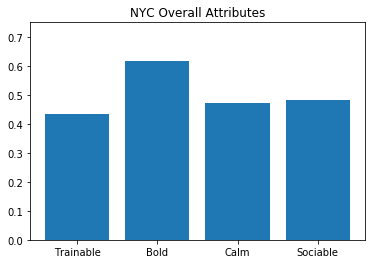


Seattle Mean
Trainable    0.60
Bold         0.60
Calm         0.55
Sociable     0.58
dtype: float64

Seattle Standard Deviation
Trainable    0.38
Bold         0.46
Calm         0.50
Sociable     0.43
dtype: float64


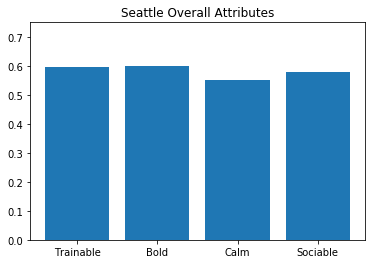


Adelaide Mean
Trainable    0.52
Bold         0.52
Calm         0.41
Sociable     0.41
dtype: float64

Adelaide Standard Deviation
Trainable    0.38
Bold         0.46
Calm         0.50
Sociable     0.43
dtype: float64


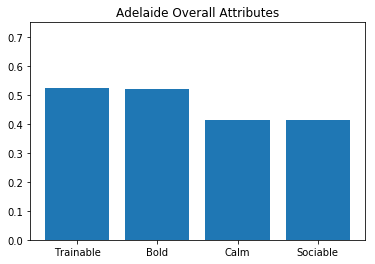


Edmonton Mean
Trainable    0.58
Bold         0.58
Calm         0.52
Sociable     0.52
dtype: float64

Edmonton Standard Deviation
Trainable    0.38
Bold         0.46
Calm         0.50
Sociable     0.43
dtype: float64


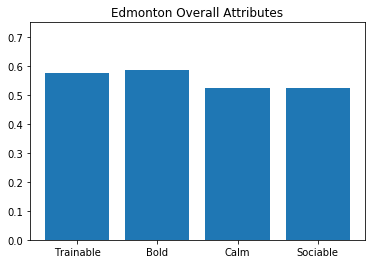

------------------------------
          Trainable      Bold      Calm  Sociable
New York   0.433729  0.615466  0.473043  0.480756
Seattle    0.597293  0.598161  0.551882  0.577961
Edmonton   0.576334  0.584502  0.523324  0.522898
Adelaide   0.522014  0.521140  0.414464  0.411995

New York
Yorkshire Terrier     7412
Shih Tzu              6835
Chihuahua             5555
Maltese               4117
Labrador Retriever    4055
Pit Bull Mix          3279
dtype: int64

Seattle
Labrador Retriever     2534
Golden Retriever       1128
Chihuahua               988
German Shepherd         549
Miniature Poodle        472
Australian Shepherd     466
dtype: int64

Edmonton
Labrador Retriever    5426
Shih Tzu              4749
German Shepherd       3732
Chihuahua             2656
Border Collie         2379
Yorkshire Terrier     2065
dtype: int64

Adelaide
Maltese                       1737
Staffordshire Bull Terrier    1001
Labrador Retriever             942
Jack Russell Terrier           911
Chihuahua

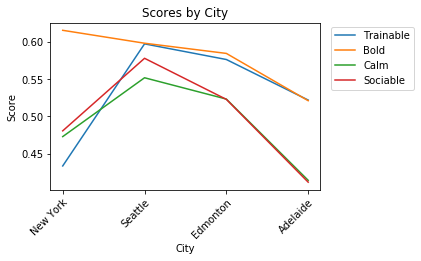

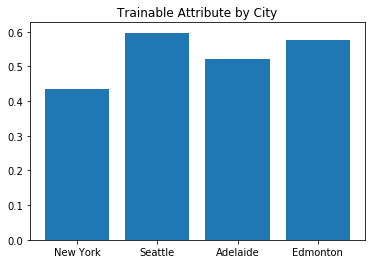

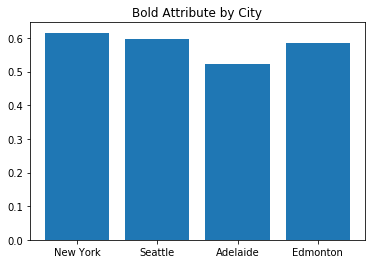

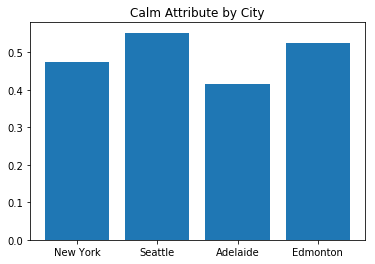

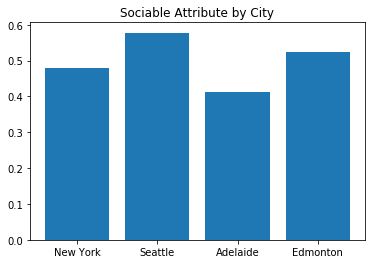

In [20]:
# Show data on NYC, Seattle, Adelaide, and Edmonton
describe(nyc_attrib, 'NYC')
describe(seattle_attrib, 'Seattle')
describe(adelaide_attrib, 'Adelaide')
describe(edmonton_attrib, 'Edmonton')
print('-'*30)    

adelaide_mean = adelaide_attrib[lst].mean()
edmonton_mean = edmonton_attrib[lst].mean()
nyc_mean = nyc_attrib[lst].mean()
seattle_mean = seattle_attrib[lst].mean()

combined = pd.concat([nyc_mean,seattle_mean,edmonton_mean,adelaide_mean], axis=1)
combined.rename(columns={0:'New York', 1:'Seattle', 2:'Edmonton', 3:'Adelaide'}, inplace=True)
combined = combined.T
print(combined)

print('\n'+'New York')
print(nyc_attrib.index.value_counts(normalize=norm).head(6))
print('\n'+'Seattle')
print(seattle_attrib.index.value_counts(normalize=norm).head(6))
print('\n'+'Edmonton')
print(edmonton_attrib.index.value_counts(normalize=norm).head(6))
print('\n'+'Adelaide')
print(adelaide_attrib.index.value_counts(normalize=norm).head(6))


plot_by_attrib(combined, lst, 'City')

for item in lst:
    plt.title(item+' Attribute by City')
    plt.bar(['New York','Seattle','Adelaide','Edmonton'], \
            [nyc_mean[item],seattle_mean[item], adelaide_mean[item], edmonton_mean[item]])
    plt.show()


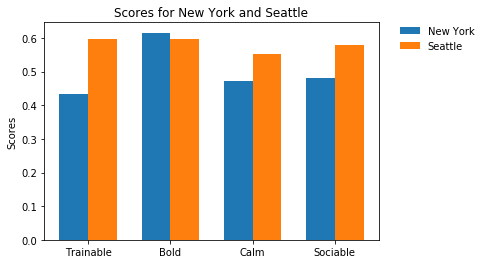

In [46]:
#     print('\n'+categ+' Mean')
#     attrib_mean = df[lst].mean()
#     print(attrib_mean.round(decimals=2))
#     print('\n'+categ+' Standard Deviation')
#     print(attrib[lst].std().round(decimals=2))

#     plt.title(categ+' Overall Attributes')
#     plt.bar(attrib_mean.index, attrib_mean.values)
#     plt.ylim([0,0.75])
#     if filename is not None:
#         plt.savefig('../plots/'+filename)
#     if display:
#         plt.show()

x = np.arange(len(nyc_mean.index))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, nyc_mean, width, label='New York')
rects1 = ax.bar(x + width/2, seattle_mean, width, label='Seattle')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores for New York and Seattle')
ax.set_xticks(x)
ax.set_xticklabels(nyc_mean.index)
ax.legend(loc='lower left', bbox_to_anchor= (1.05, .85), ncol=1, 
            borderaxespad=0, frameon=False)

plt.show()

## Ancestral origin: looking at the UK and Ireland


UK and Ireland Mean
          Obedient  Calm  Trainable  Sociable  Bold
Origin                                             
England       0.52  0.70        0.4      0.65   0.7
Ireland       0.62  0.75        0.5      0.62   0.5
Scotland      0.59  0.80        0.6      0.80   0.8
Wales         0.59  0.00        1.0      0.00   0.0

UK and Ireland Standard Deviation
          Obedient  Calm  Trainable  Sociable  Bold
Origin                                             
England       0.18  0.48       0.32      0.47  0.42
Ireland       0.15  0.50       0.41      0.48  0.58
Scotland      0.25  0.45       0.22      0.45  0.45
Wales         0.24   NaN        NaN       NaN   NaN

UK and Ireland Count
          Obedient  Calm  Trainable  Sociable  Bold
Origin                                             
England         19    10         10        10    10
Ireland          6     4          4         4     4
Scotland        10     5          5         5     5
Wales            4     1          1   

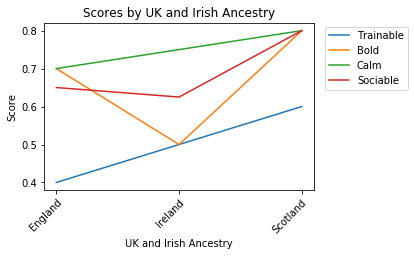

UK breeds:
2                         Bloodhound
4                        Bullmastiff
10                       Otter Hound
39                Labrador Retriever
59                  Airedale Terrier
66                     Border Collie
75             Flat-Coated Retriever
106                   Border Terrier
111    Cavalier King Charles Spaniel
115              English Toy Spaniel
117                      Fox Terrier
Name: Breed, dtype: object

Ireland breeds:
8                 Irish Wolfhound
37                   Irish Setter
78                  Irish Terrier
79            Irish Water Spaniel
81             Kerry Blue Terrier
93    Soft-Coated Wheaten Terrier
Name: Breed, dtype: object


In [21]:
ancestral = wiki[['Breed', 'Origin']]
ancestral_uk_ire = ancestral.copy()
ancestral_uk_ire.dropna(inplace=True)
ancestral_uk_ire = ancestral_uk_ire[ancestral_uk_ire['Origin'].isin(['England', 'Scotland', 'Wales', 'Ireland'])]
ancestral_uk_ire = ancestral_uk_ire.set_index('Breed').join(attrib, how='inner')
ancestral_uk_ire_grp = ancestral_uk_ire.groupby('Origin')
ancestral_uk_ire_mean = ancestral_uk_ire_grp.mean()
print('\nUK and Ireland Mean')
print(ancestral_uk_ire_grp.mean().round(decimals=2))
print('\nUK and Ireland Standard Deviation')
print(ancestral_uk_ire_grp.std().round(decimals=2))
print('\nUK and Ireland Count')

print(ancestral_uk_ire_grp.count())

# Plot the UK and Ireland data
# Remove Wales since it only has one dog for some of the data
ancestral_uk_ire_mean.drop('Wales', inplace=True)
plot_by_attrib(ancestral_uk_ire_mean, lst, 'UK and Irish Ancestry')

# Combining Scotland, Wales, and England as United Kingdom
ancestral['Origin'] = ancestral['Origin'].map(lambda x: 'United Kingdom' if x in {'England', 'Wales', 'Scotland'} else x)
ancestral_attrib = ancestral.set_index('Breed').join(attrib, how='inner')

print('UK breeds:')
wiki.fillna('', inplace=True)
print(wiki[wiki['Origin'].str.contains("United Kingdom")]['Breed'])

print('\nIreland breeds:')
print(wiki[wiki['Origin'].str.contains("Ireland")]['Breed'])

## Hypothesis testing

In [22]:
ancestral_attrib.dropna(inplace=True)
ancestral_attrib2 = splitDataFrameList(ancestral_attrib,'Origin', '/')
ancestral_attrib2['Origin'] = ancestral_attrib2['Origin'].map(lambda x: 'China' if x == 'Tibet (China)' else x)


print('Alternative Hypothesis: Dogs with ancestry from the UK are bolder than other dogs.')
ancestral_uk = ancestral_attrib2[ancestral_attrib2['Origin'] == 'United Kingdom']
ancestral_not_uk = ancestral_attrib2[~(ancestral_attrib2['Origin'] == 'United Kingdom')]
ancestral_uk_bold = ancestral_uk['Bold']
print('Ancestral UK Bold Mean:')
print(ancestral_uk_bold.mean())
ancestral_uk_bold.dropna(inplace=True)
ancestral_not_uk_bold = ancestral_not_uk['Bold']
ancestral_not_uk_bold.dropna(inplace=True)
print('Ancestral Non-UK Bold Mean:')
print(ancestral_not_uk_bold.mean())
print(stats.ttest_ind(ancestral_uk_bold, ancestral_not_uk_bold, equal_var = False))

Alternative Hypothesis: Dogs with ancestry from the UK are bolder than other dogs.
Ancestral UK Bold Mean:
0.6818181818181818
Ancestral Non-UK Bold Mean:
0.313953488372093
Ttest_indResult(statistic=3.1133301873945967, pvalue=0.00331078574427337)


The p-value of 0.003 is less than 0.05, so we reject the null hypothesis. UK dogs are bolder than other dogs.

In [23]:
print('Null Hypothesis: The average obedience of UK dogs is the same as non-UK dogs.')
print('Alternative Hypothesis: The average obedience of UK dogs is different from non-UK dogs.')
ancestral_uk_obedient = ancestral_uk['Obedient']
ancestral_not_uk_obedient = ancestral_not_uk['Obedient']
print(stats.ttest_ind(ancestral_uk_obedient, ancestral_not_uk_obedient, equal_var = False))

Null Hypothesis: The average obedience of UK dogs is the same as non-UK dogs.
Alternative Hypothesis: The average obedience of UK dogs is different from non-UK dogs.
Ttest_indResult(statistic=0.3567621595443657, pvalue=0.7229897586669409)


The p-value of 0.822 is greater than 0.05, so we fail to reject the null hypothesis. UK dogs are of average obedience.

## German dogs

In [24]:
print('German breeds:')
print(wiki[wiki['Origin'].str.contains("Germany")]['Breed'])

print('\nAlternative Hypothesis: Dogs with German ancestry are more obedient than other dogs.')
ancestral_ger = ancestral_attrib2[ancestral_attrib2['Origin'] == 'Germany']
ancestral_not_ger = ancestral_attrib2[~(ancestral_attrib2['Origin'] == 'Germany')]
ancestral_ger_obedient = ancestral_ger['Obedient']
print('Ancestral Germany Obedient Mean:')
print(ancestral_ger_obedient.mean())
ancestral_ger_obedient.dropna(inplace=True)
ancestral_not_ger_obedient = ancestral_not_ger['Obedient']
ancestral_not_ger_obedient.dropna(inplace=True)
print('Ancestral Non-Germany Obedient Mean:')
print(ancestral_not_ger_obedient.mean())
print(stats.ttest_ind(ancestral_ger_obedient, ancestral_not_ger_obedient, equal_var = False))

German breeds:
5                       Great Dane
11                      Rottweiler
22                           Boxer
27               Doberman Pinscher
30                 German Shepherd
31      German Shorthaired Pointer
32       German Wirehaired Pointer
33                 Giant Schnauzer
41                          Poodle
42                Miniature Poodle
43                      Toy Poodle
51                      Pomeranian
58                      Weimaraner
80                        Keeshond
86                     Plott Hound
95              Standard Schnauzer
99     Wirehaired Pointing Griffon
100                American Eskimo
113                      Dachshund
119                German Pinscher
138                  Affenpinscher
Name: Breed, dtype: object

Alternative Hypothesis: Dogs with German ancestry are more obedient than other dogs.
Ancestral Germany Obedient Mean:
0.7541666666666668
Ancestral Non-Germany Obedient Mean:
0.5726415094339623
Ttest_indResult(statistic=2.7

The p-value of 0.009 is less than 0.05, so we reject the null hypothesis. German dogs are more obedient than other dogs.

In [25]:
print('Alternative Hypothesis: Dogs with German ancestry are less calm than other dogs.')
ancestral_ger_calm = ancestral_ger['Calm']
print('Ancestral Germany Calm Mean:')
print(ancestral_ger_calm.mean())
ancestral_ger_calm.dropna(inplace=True)
ancestral_not_ger_calm = ancestral_not_ger['Calm']
ancestral_not_ger_calm.dropna(inplace=True)
print('Ancestral Non-Germany Calm Mean:')
print(ancestral_not_ger_calm.mean())
print(stats.ttest_ind(ancestral_ger_calm, ancestral_not_ger_calm, equal_var = False))

Alternative Hypothesis: Dogs with German ancestry are less calm than other dogs.
Ancestral Germany Calm Mean:
0.08333333333333333
Ancestral Non-Germany Calm Mean:
0.5660377358490566
Ttest_indResult(statistic=-4.468667004142404, pvalue=0.00011605889988818817)


The p-value of 0.0001 is less than 0.05, so we reject the null hypothesis. German dogs are less calm than other dogs.